plot figure with TSG, MUR, ship data and goes data of SST to reply to reviewer asking if the SST at 6m is representative of the surface sst.


In [46]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import matplotlib.ticker as ticker

def f_find_closest_data_point(lat, lon, dataset_var, string):
    '''
    input: 
    - lat: latitude array from the position to look for
    - lon: longitude array from the position to look for
    - dataset_var: xarray 2d variable dependent on lat/lon to search values closest
    - string: string identifying the type of dataset
    '''
    var_closest = np.zeros((len(lat)))
    var_closest.fill(np.nan)
                           
    # loop on the serie of values
    for ind_time in range(len(lat)):
        lat_sel = lat[ind_time]
        lon_sel = lon[ind_time]
        
        if np.isnan(lat_sel) or np.isnan(lon_sel):
            var_closest[ind_time] = np.nan
        else:
            var_sel_lat = dataset_var.sel(lat=lat[ind_time], method='nearest')
            var_sel_long = var_sel_lat.sel(lon=lon[ind_time], method='nearest')
            if string == 'mur':
                var_closest[ind_time] = var_sel_long.__xarray_dataarray_variable__.values
            else:
                #print(var_sel_long.analysed_sst.values)
                var_closest[ind_time] = var_sel_long.analysed_sst.values


    return(var_closest)
                           

In [29]:
# define paths to the data
tsg_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc'
mur_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/satellite_data/submitted/2-3 Feb LT_SST_MUR_regridded.nc'
ship_file = '/Volumes/Extreme SSD/ship_motion_correction_merian/ship_data/new/ship_dataset_allvariables.nc'

ship = xr.open_dataset(ship_file)
mur = xr.open_dataset(mur_file)


# reading tsg data and creating xarray dataset
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
sst_dataset      = xr.Dataset(data_vars = variables,
                       coords = coords)

# reading ship data and extracting the time interval of interest
ship_slice = ship.sel(time=slice(t_start, t_end))
ship_slice

<xarray.Dataset>
Dimensions:  (time: 172604)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02 ... 2020-02-03T23:59:59
Data variables:
    lcl      (time) float64 ...
    P        (time) float64 ...
    T        (time) float64 ...
    RH       (time) float64 ...
    SST      (time) float64 ...
    lat      (time) float64 ...
    lon      (time) float64 ...
    Hwind    (time) float64 ...
    windDir  (time) float64 ...
Attributes:
    created_by:  Claudia Acquistapace
    created_on:  2021-01-28 09:39:01.826265
    comment:     basic thermodynamic variables from RV Merian

In [35]:
# reading GOES dataset 
GOES_path = '/Volumes/PortableSSD/GOES_data/day_night/'
GOES_list = np.sort(glob.glob(GOES_path+'*.nc'))

# reading goes data 
goes_02 = xr.open_mfdataset(GOES_list[0])
goes_03 = xr.open_mfdataset(GOES_list[1])

# slicing lat lon for the two separate days
t_end_2 = datetime(2020, 2, 2, 23, 59, 59)
t_start_2 = datetime(2020, 2, 2, 0, 0, 0)
t_end_3 = datetime(2020, 2, 3, 23, 59, 59)
t_start_3 = datetime(2020, 2, 3, 0, 0, 0)
sliced_tsg_ds_2 = tsg_data.sel(TIME=slice(t_start_2, t_end_2))
sliced_tsg_ds_3 = tsg_data.sel(TIME=slice(t_start_3, t_end_3))

sst_goes_2 = f_find_closest_data_point(sliced_tsg_ds_2.LATITUDE.values,  sliced_tsg_ds_2.LONGITUDE.values, goes_02, 'goes')
sst_goes_3 = f_find_closest_data_point(sliced_tsg_ds_3.LATITUDE.values,  sliced_tsg_ds_3.LONGITUDE.values, goes_03, 'goes')


AttributeError: module 'numpy' has no attribute 'merge'

In [37]:
sst_goes = np.concatenate([sst_goes_2, sst_goes_3])

In [38]:
len(sst_goes)


2880

In [39]:
# extract from lat lon of the mur map the closest to the ship position

sst_mur = f_find_closest_data_point(sliced_tsg_ds.LATITUDE.values,  sliced_tsg_ds.LONGITUDE.values, mur, 'mur')
len(sst_mur)

2880

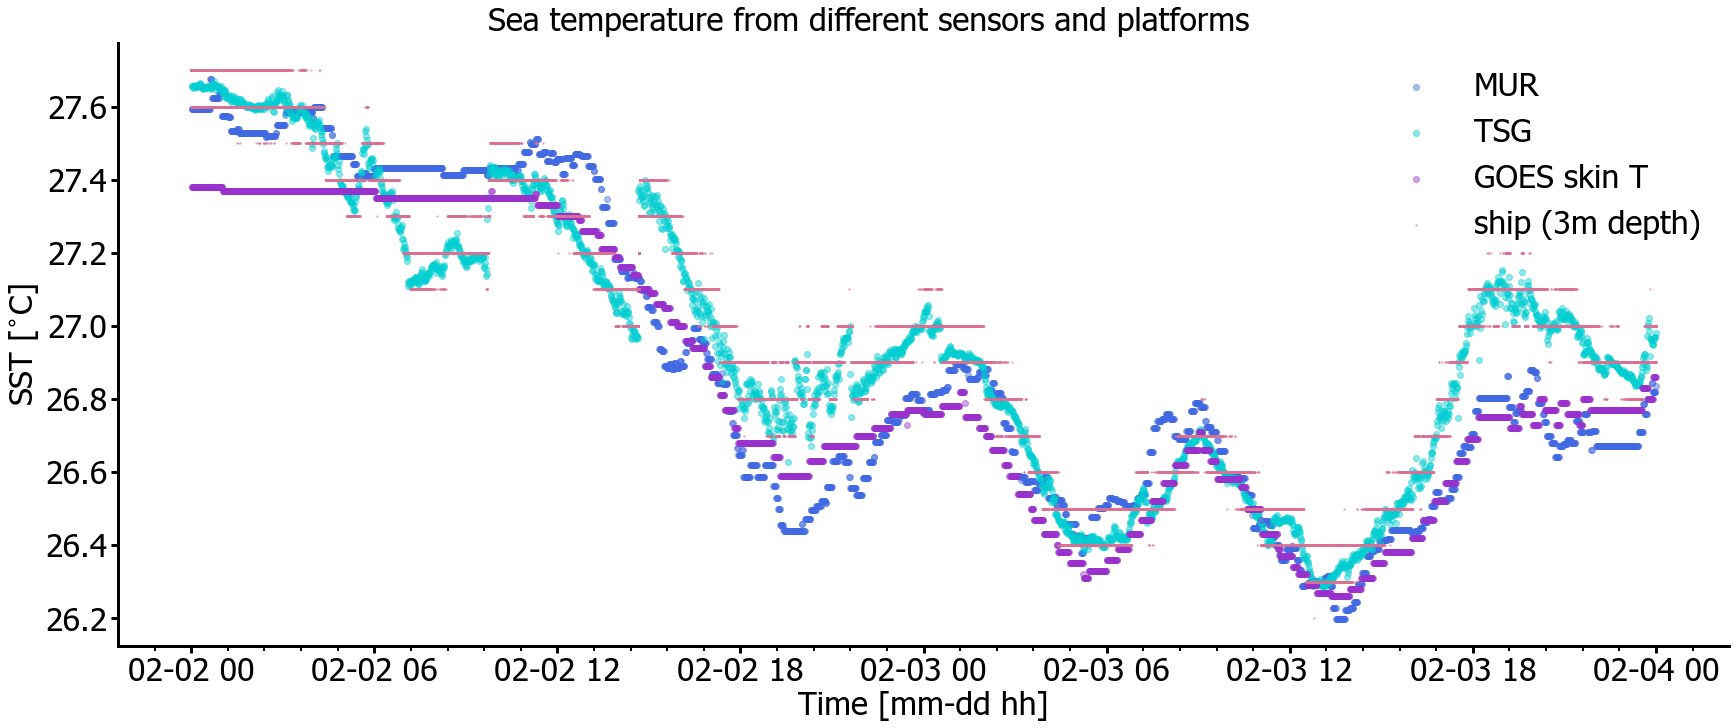

In [60]:
from matplotlib import rcParams
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'

dict_plot_settings = {
    'labelsize'    :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}

fig, axs = plt.subplots(1,1, figsize=(24,10), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Sea temperature from different sensors and platforms", fontsize=32)
# colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'),
# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})    
#ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(which='minor', length=5, width=2)
axs.tick_params(which='major', length=7, width=3)
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs.tick_params(axis='both', labelsize=32)
axs.set_xlabel('Time [mm-dd hh]')
axs.set_ylabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

plt.scatter(sliced_tsg_ds.TIME.values, sst_mur, label='MUR', color='royalblue', alpha=0.45,)
plt.scatter(sliced_tsg_ds.TIME.values, sst_dataset.SST.values, label='TSG', color='darkturquoise', alpha=0.45,)
plt.scatter(sliced_tsg_ds.TIME.values, sst_goes-273.15, label='GOES skin T', color='darkorchid', alpha=0.45,)
plt.scatter(ship_slice.time.values, ship_slice.SST.values, label='ship (3m depth)', s=2., alpha=0.45, color='palevioletred')
plt.legend(frameon=False)
fig.savefig(path_out_plots+'revierew_1_sst.png', format='png')

In [61]:
path_out_plots

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'